# Bounding box detection
To perform the detection of the bounding boxes, we will only use the library of OpenCV.

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from joblib import Parallel, delayed

### Definition of the constants to test the algorithm

In [11]:
group = 9
student = 3

### Usefull functions to load the images and the data

In [12]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    return np.array(cv2.imreadmulti(f'./data/sequences/{group}-{student}.tif', flags=cv2.IMREAD_GRAYSCALE)[1])

### Background definition
To compute the background, we simply take the average of the images of the video.

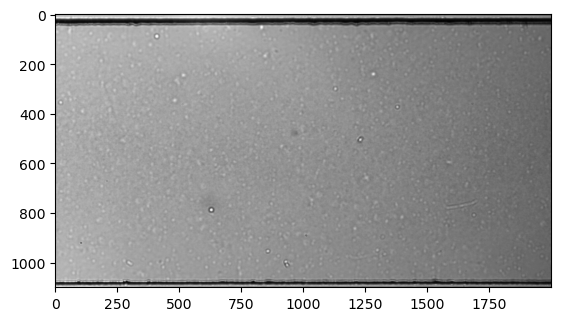

In [13]:
images = load_images(group,student)
masks = np.zeros(images.shape)
back = np.mean(images,axis=0)
plt.imshow(back,cmap='gray');

### First mask definition
To define the first mask, we will use the background and a threshold to define the mask. We normalize the substraction with the maximum value of the the image.

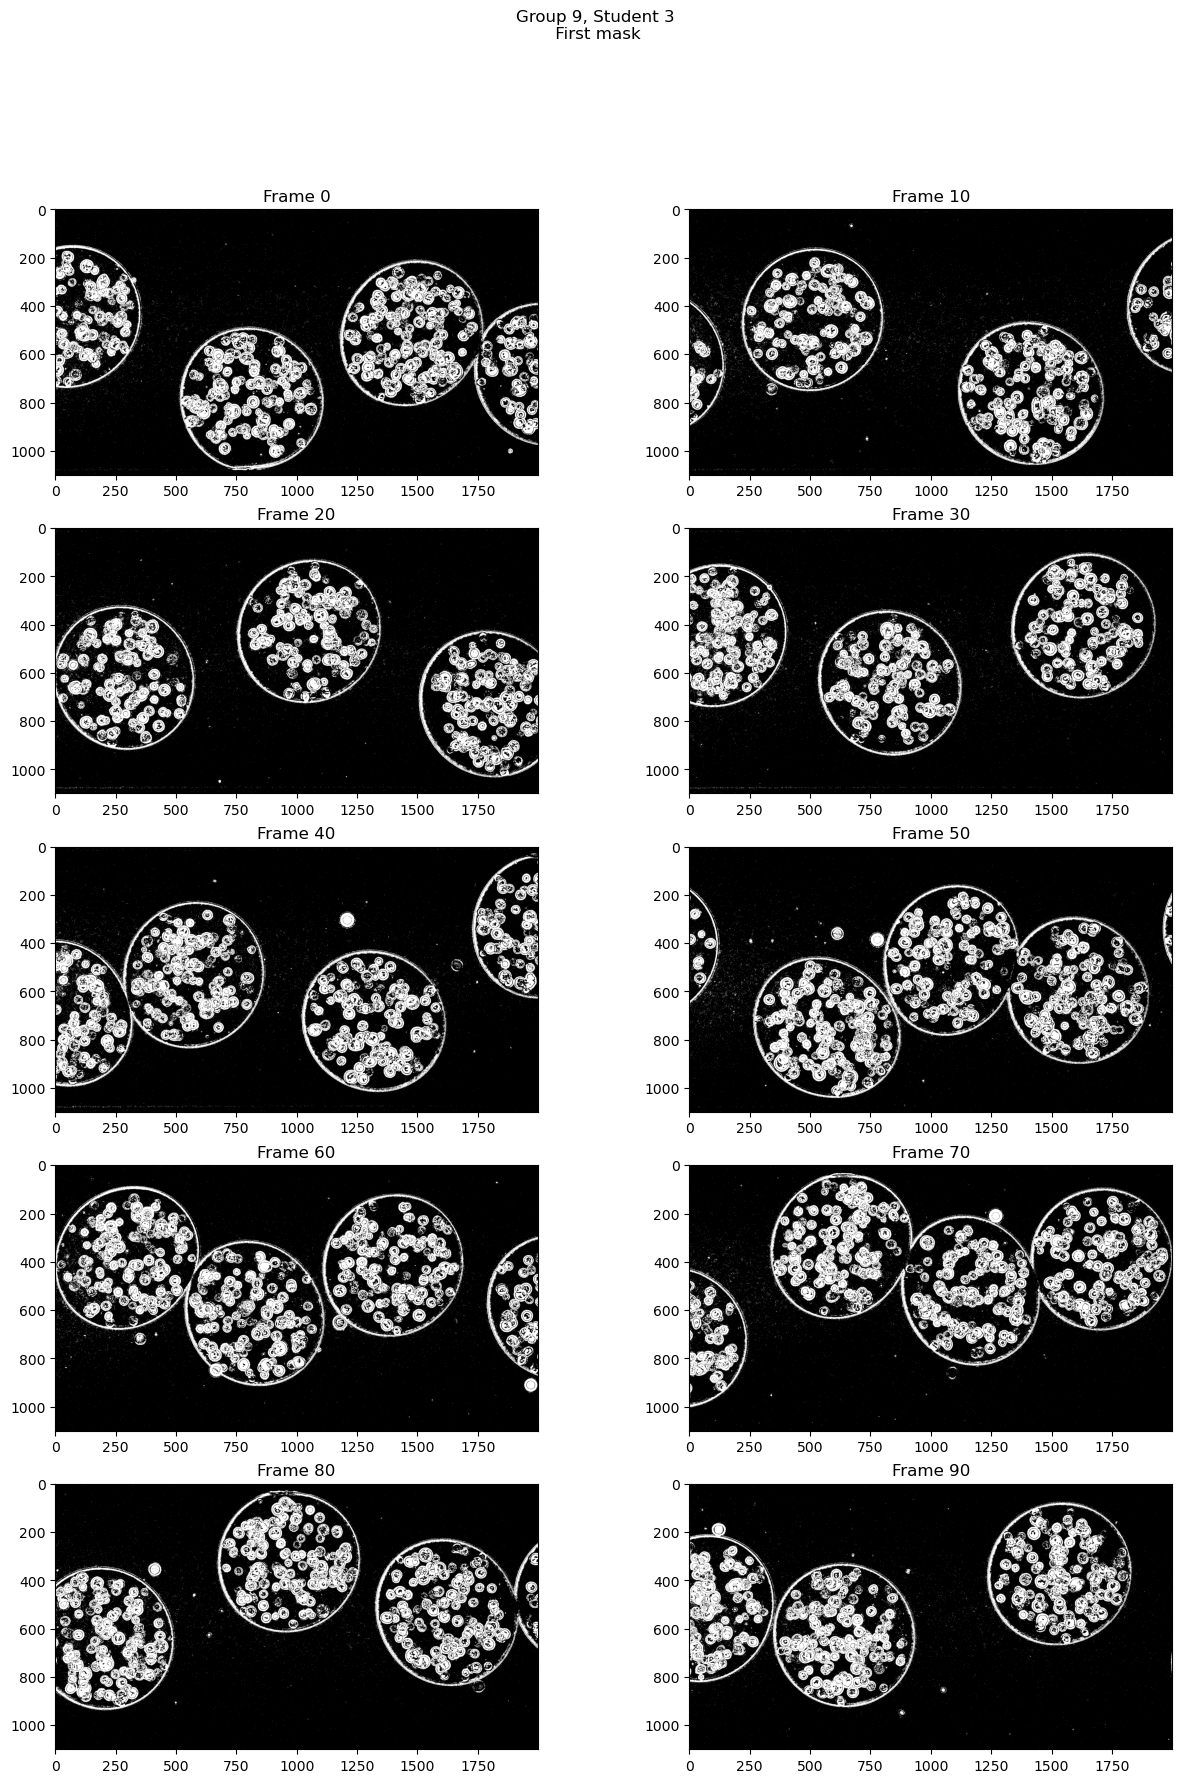

In [25]:
def process_images(images, back):
    def get_mask(image, back):
        return np.abs(image - back) / np.max(image) > 0.1

    masks = Parallel(n_jobs=8)(delayed(get_mask)(image, back) for image in images)
    masks = np.array(masks)
    masks = masks.astype(np.uint8) * 255
    return masks

masks = process_images(images, back)
fig, axs = plt.subplots(5, 2, figsize=(15,20))
fig.suptitle(f'Group {group}, Student {student}\n First mask')
for i, ax in enumerate(axs.flatten()):
    ax.imshow(masks[i*10], cmap='gray')
    ax.set_title(f'Frame {i*10}')
plt.show()

### Cleaning the mask and definition of the bounding boxes

In [31]:
def get_contours(masks, frame):
    def clean_frame(mask):
        image = mask.copy()
        image = cv2.medianBlur(image, 3)
        
        kernel = np.ones((3,3),np.uint8)
        image = cv2.dilate(image, kernel, iterations=9)

        image = cv2.medianBlur(image, 17)

        contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        image = np.zeros(image.shape)
        bb = []
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(image, [contour], 0, (255), -1)
                x, y, w, h = cv2.boundingRect(contour)
                bb.append((x, y, w, h))
                cv2.rectangle(image, (x, y), (x+w, y+h), (255), 2)

    
        kernel = np.ones((100,100),np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        image = np.array(image, dtype=np.uint8)
        return image

    def get_boundaries(mask):
        boundaries = np.zeros(mask.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if cv2.contourArea(contour) > 300:
                cv2.drawContours(boundaries, [contour], 0, (255), 5)
        return np.array(boundaries, dtype=np.uint8)

    def get_circles(mask):
        return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=500, param1=50, param2=20, minRadius=270, maxRadius=350)

    def get_bounding_boxes(mask):
        circles = get_circles(mask)
        bb = []
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0,:]:
                x, y, r = circle
                x = int(x)
                y = int(y)
                r = int(r)
                if x-r < 0 or y-r < 0 or x+r > mask.shape[1] or y+r > mask.shape[0]:
                    continue
                bb.append((x-r, y-r, 2*r, 2*r))
        return bb
    
    mask = masks[frame-1]
    mask = clean_frame(mask)
    mask = get_boundaries(mask)
    bb   = get_bounding_boxes(mask)
    return mask, bb

### Results

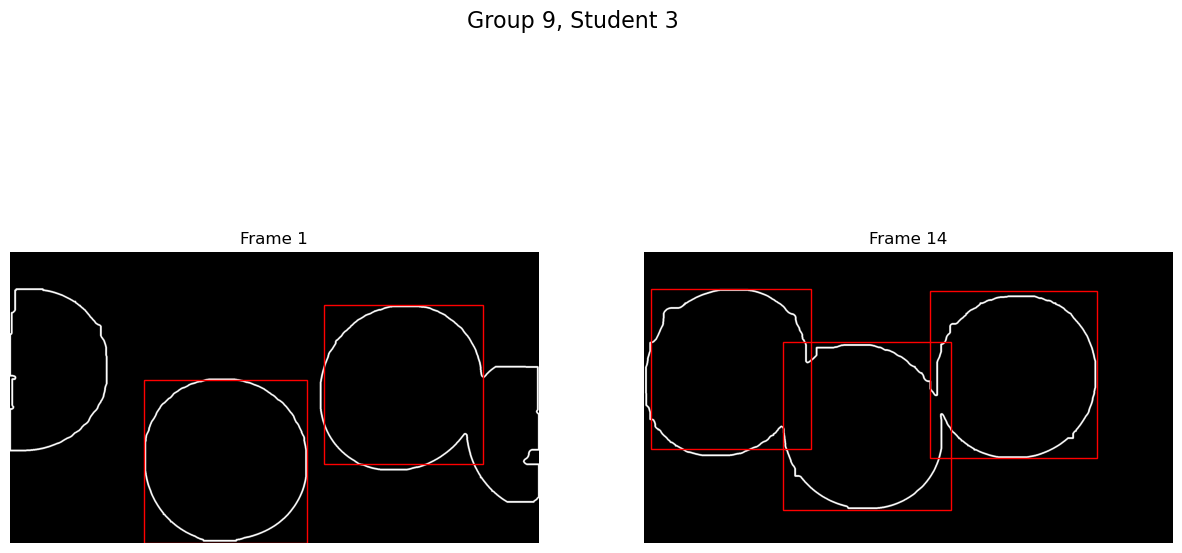

In [32]:
frames = np.random.randint(1, 100, 10)

frames = [1,14]
fig, axs = plt.subplots(len(frames)//2, 2, figsize=(15, 5 + 3*len(frames)//2))
title = f'Group {group}, Student {student}'
fig.suptitle(title, fontsize=16)
for i, ax in enumerate(axs.flatten()):
    mask, bb = get_contours(masks, frames[i])
    ax.imshow(mask, cmap='gray')
    for x, y, w, h in bb:
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red'))
    ax.set_title(f'Frame {frames[i]}')
    ax.axis('off')

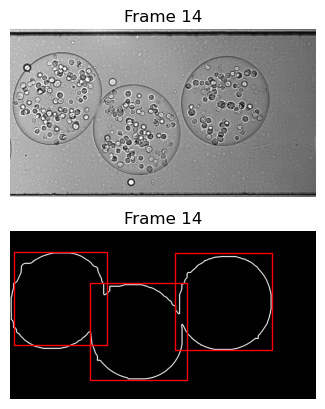

In [36]:
frame = 14

image = images[frame-1]
mask, bb = get_contours(masks, frame)

fig, axs = plt.subplots(2,1)
axs[0].imshow(image, cmap='gray')
axs[0].set_title(f'Frame {frame}')
axs[0].axis('off')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f'Frame {frame}')
axs[1].axis('off')
for x, y, w, h in bb:
    axs[1].add_patch(plt.Rectangle((x, y), w, h, fill=False, color='red'))
plt.show()


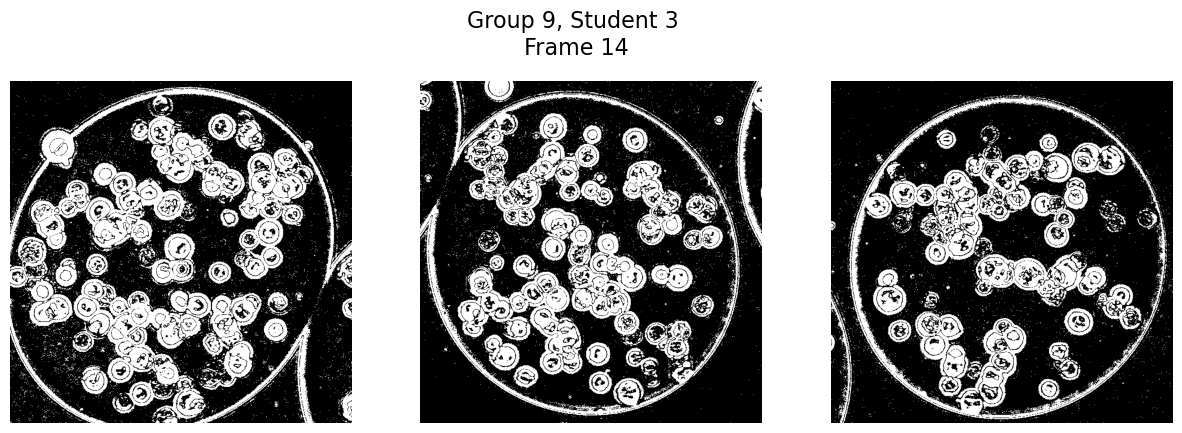

In [37]:
frame = 14
shrinked = list()
_, bb = get_contours(masks, frame)
for x, y, w, h in bb:
    shrinked.append(masks[frame-1][y:y+h, x:x+w])
# invert the list
shrinked = shrinked[::-1]

fig, axs = plt.subplots(1, len(shrinked), figsize=(15, 5))
fig.suptitle(f'Group {group}, Student {student}\n Frame {frame}', fontsize=16)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(shrinked[i], cmap='gray')
    ax.axis('off')
plt.show()
